## Detection of correlated input to FS with and without gap junctions.

There are two population units for FS neurons, population unit 1 and population unit 2. In addition there are FS units without a population unit (0). The two population units receive cortical and thalamic input with 2Hz frequency. The correlation of population unit 1 is increased between 1 and 1.1 seconds for the cortical input, and between 2 and 2.1 seconds for the thalamic input.

In [1]:
import os
import numpy as np

os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = os.path.join("networks", "FS_correlation_detection")

In [2]:
from snudda import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=12345)
si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=20, num_LTS=0, num_ChIN=0)

# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
# First test, we place units on top of each other -- set num_neurons to 8
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 0]),
                               probability_function="(d < 200e-6)*1", num_neurons=7)
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0,0,0]),
                               probability_function="(d < 200e-6) * 1", num_neurons=7)
 
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Writing networks/FS_correlation_detection/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

### Plotting the network
Plotting the network to verify that the population units are placed the way we expect.

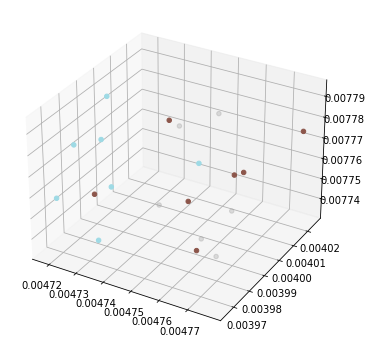

In [4]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

### Check if ipyparallel running
For larger networks it is useful to run network creation in parallel.

In [5]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Warning, running in serial.


In [6]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc, verbose=False)
sd.detect()

No d_view specified, running distribute neurons in serial
Processing hyper voxel : 122/294 (20 neurons)
Processing hyper voxel : 121/294 (20 neurons)
Processing hyper voxel : 114/294 (20 neurons)
Processing hyper voxel : 115/294 (20 neurons)
Processing hyper voxel : 65/294 (16 neurons)
Processing hyper voxel : 171/294 (15 neurons)
Processing hyper voxel : 66/294 (14 neurons)
Processing hyper voxel : 163/294 (13 neurons)
Processing hyper voxel : 164/294 (13 neurons)
Processing hyper voxel : 72/294 (13 neurons)
Processing hyper voxel : 113/294 (12 neurons)
Processing hyper voxel : 73/294 (12 neurons)
Processing hyper voxel : 107/294 (11 neurons)
Processing hyper voxel : 120/294 (10 neurons)
Processing hyper voxel : 108/294 (10 neurons)
Processing hyper voxel : 170/294 (9 neurons)
Processing hyper voxel : 157/294 (7 neurons)
Processing hyper voxel : 128/294 (7 neurons)
Processing hyper voxel : 59/294 (7 neurons)
Processing hyper voxel : 71/294 (6 neurons)
Processing hyper voxel : 116/294 

In [7]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc, verbose=False)
sp.prune()

Read 7070 out of total 7070 synapses
Read 1128 out of total 1128 gapJunctions


### Generate input

Next we generate the input according to specifications in [FS-input-correlation-detection-1.json](FS-input-correlation-detection-1.json)

In [8]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("FS-input-correlation-detection-1.json"),
                 time=2,
                 rc=rc, verbose=False)
si.generate()

Loading 20 neurons with 854 synapses and 716 gap junctions
Writing spikes to networks/FS_correlation_detection/input-spikes.hdf5


### Plot the input to verify it looks reasonable

In [9]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

Loading 20 neurons with 854 synapses and 716 gap junctions


Input to FS population unit 1. Here we have a correlation increase in cortical input between 1 and 1.1 seconds, and in thalamic input between 2 and 2.1 seconds.

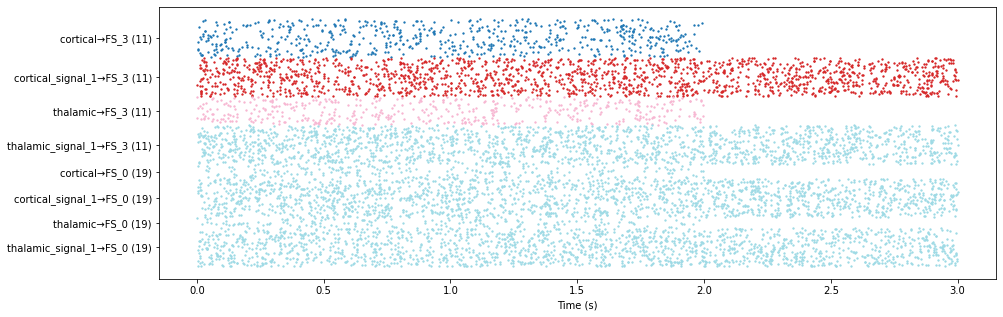

In [10]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS population unit 2 receives elevated input but no change in correlation.

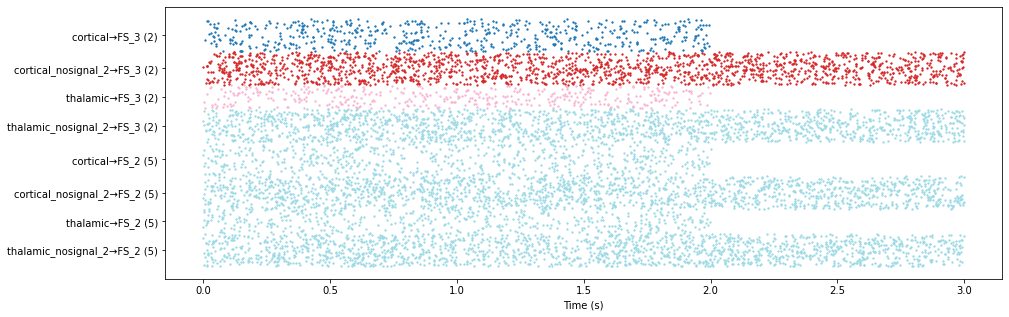

In [11]:
spi.plot_input_population_unit(population_unit_id=2, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS neurons without population unit receive the same low background input constantly.

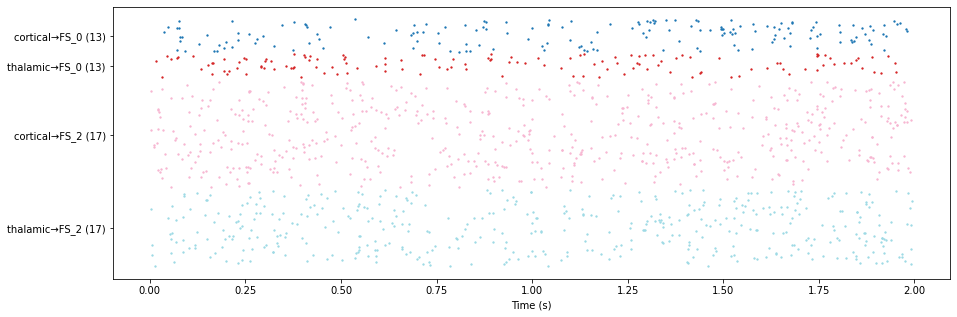

In [12]:
spi.plot_input_population_unit(population_unit_id=0, num_neurons=2, neuron_type="FS", fig_size=(15,5))

### Compile neuron modules

In [13]:
!nrnivmodl ../../../../BasalGangliaData/data/neurons/mechanisms

/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/ca_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal12_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal13_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caldyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cap_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caq_fs.mod" "../

### Run the simulation

In [14]:
!mpiexec -n 2 snudda simulate networks/FS_correlation_detection --time 2

numprocs=2
Using input file networks/FS_correlation_detection/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
args: Namespace(action='simulate', disable_gj=False, disable_synapses=False, exportCoreNeuron=False, input_file=None, mech_dir=None, network_file=None, neuromodulation=None, output_file=None, path='networks/FS_correlation_detection', profile=False, randomseed=None, record_all=None, record_volt=True, time=2.0, verbose=False)
Using input file networks/FS_correlation_detection/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
args: Namespace(action='simulate', disable_gj=False, disable_synapses=False, exportCoreNeuron=False, input_file=None, mech_dir=None, netw

In [ ]:
!mpiexec -n 2 snudda simulate networks/FS_correlation_detection --time 2 --disableGJ --outputFile networks/FS_correlation_detection/simulation/output-no-GJ.hdf5

In [ ]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc1 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc1.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr-no-gj.png"))

### Plotting

We want to plot the binned frequency for the different populations as a function of time, to see if there is a difference in output frequency during 1-1.1 seconds and 2-2.1 seconds. 